In [3]:
from collections import defaultdict
import numpy as np
from scipy.sparse import csc_matrix, save_npz, load_npz
import time
import gzip
from itertools import product
import json

In [4]:
# Pull arguments
reference = 'hg19'
vcf_files = ['../data/GenotypeFiles/High_Confidence_Calls_HG19.vcf.gz', 
             '../data/GenotypeFiles/manuscript_supplement_filtered_ped_consistent.vcf.gz',
             '../data/GenotypeFiles/manuscript_supplement_hq_fails.vcf.gz']
out_dir = '../../DATA/platinum/genotypes'
maxsize = 500000000

In [5]:
with open('%s/info.json' % out_dir, 'w+') as f:
    json.dump({
        "assembly": "37",
        "batch_size": -1,
        "vcf_directory": "/scratch/PI/dpwall/DATA/platinumGenomes/GenotypeFiles"
    }, f)


In [8]:
# pull sample_ids and write to file
chrom = 'chr1'
with gzip.open(vcf_files[0], 'rt') as f:
    # Skip header
    line = next(f)
    while line.startswith('##'):
        line = next(f)

with open('%s/samples.json' % out_dir, 'w+') as sample_f:
    sample_ids = line.strip().split('\t')[9:]
    json.dump(sample_ids, sample_f)

sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])
m = len(sample_ids)
print('Num individuals with genomic data', len(sample_ids))

Num individuals with genomic data 13


In [16]:

#for chrom in ['chr%d' % c for c in range(1, 23)]:
for chrom in ['chrX']:
    chrom_int = 23 if chrom=='chrX' else 24 if chrom=='chrY' else int(chrom[3:])

    t0 = time.time()

    with gzip.open(vcf_files[0], 'rt') as f:
        # Skip header
        line = next(f)
        while line.startswith('##'):
            line = next(f)

    # Pull data from vcf
    variant_info = []
    chrom_coord = []

    # Pull genotypes from vcf
    m = len(sample_ids)
    data, indices, indptr = np.zeros((maxsize,), dtype=np.int8), np.zeros((maxsize,), dtype=int), [0]
    gen_mapping = {'./.': -1, '0/0': 0, '0|0': 0, '0/1': 1, '0|1': 1, '1/0': 1, '1|0': 1, '1/1': 2, '1|1': 2}
    index, num_lines = 0, 0
    
    refs = []
    alts = []

    for vcf_file in vcf_files:
        print(vcf_file)
        with gzip.open(vcf_file, 'rt') as f:

            # Skip header
            line = next(f)
            while line.startswith('##'):
                line = next(f)

            sample_ids = line.strip().split('\t')[9:]
            col_indices = [sample_id_to_index[x] for x in sample_ids]

            line = next(f)
            for line in f:
                pieces = line.split('\t', maxsplit=1)

                if pieces[0] == chrom:
                    pieces = line.strip().split('\t')
                    _, pos, _, ref, alt = pieces[:5]
                    is_biallelic_snp = len(ref) == 1 and len(alt) == 1 and ref != '.' and alt != '.'
                    
                    if is_biallelic_snp and 'bwa_gatk' in pieces[7]:
                        refs.append(ref)
                        alts.append(alt)
                        fmt = pieces[8].strip().split(':')

                        # Write variant to file
                        variant_info.append('\t'.join(pieces[:9]) + '\n')
                        chrom_coord.append((chrom_int, int(pos), is_biallelic_snp, True))

                        # Pull out genotypes
                        gen_index = fmt.index('GT')
                        for i, piece in zip(col_indices, pieces[9:]):
                            segment = piece.split(':', maxsplit=gen_index+1)
                            gt = gen_mapping.get(segment[gen_index], -1) # For now we mark multi-base loci as unknown

                            if gt != 0:
                                indices[index] = i
                                data[index] = gt
                                index += 1
                        indptr.append(index)
                        num_lines += 1

    # reorder since data is coming from multiple files
    chrom_coord = np.asarray(chrom_coord, dtype=int)
    ordered_indices = np.argsort(chrom_coord[:, 1])

    chrom_coord = chrom_coord[ordered_indices, :]
    gen = csc_matrix((data[:index], indices[:index], indptr), shape=(m, num_lines), dtype=np.int8)[:, ordered_indices]
    refs = [refs[i] for i in ordered_indices]
    alts = [alts[i] for i in ordered_indices]
    
    # remove sites with same alt and genotypes
    keep_site = np.ones((chrom_coord.shape[0],), dtype=bool)
    for i in np.where(chrom_coord[:-1, 1] == chrom_coord[1:, 1])[0]:
        # positions are the same
        if alts[i] == alts[i+1] and np.all(gen[:, i].A.flatten() == gen[:, i+1].A.flatten()):
            keep_site[i+1] = False
        elif alts[i] != alts[i+1]:
            keep_site[i] = False
            keep_site[i+1] = False
            print(chrom_coord[i, 1], 'Alt mismatch', alts[i], alts[i+1], refs[i], refs[i+1])
        else:
            keep_site[i] = False
            keep_site[i+1] = False
            print(chrom_coord[i, 1], 'Gens mismatch', gen[:, i].A.flatten(), gen[:, i+1].A.flatten())
    print(np.sum(chrom_coord[:-1, 1] == chrom_coord[1:, 1]), chrom_coord.shape[0])
    
    with gzip.open('%s/chr.%s.0.gen.variants.txt.gz' % (out_dir, chrom[3:]), 'wt') as variant_f:
        for i, keep in zip(ordered_indices, keep_site):
            if keep:
                variant_f.write(variant_info[i])

    # Save to file
    print(gen.shape)
    save_npz('%s/chr.%s.0.gen' % (out_dir, chrom[3:]), gen[:, keep_site])
    np.save('%s/chr.%s.0.gen.coordinates' % (out_dir, chrom[3:]), chrom_coord[keep_site, :])

    print('Completed in ', time.time()-t0, 'sec')


../data/GenotypeFiles/High_Confidence_Calls_HG19.vcf.gz
../data/GenotypeFiles/manuscript_supplement_filtered_ped_consistent.vcf.gz
../data/GenotypeFiles/manuscript_supplement_hq_fails.vcf.gz
0 127699
(13, 127699)
Completed in  14.43817687034607 sec


In [17]:
chrom_coord = np.load('%s/chr.X.0.gen.coordinates.npy' % out_dir)
gen_data = load_npz('%s/chr.X.0.gen.npz' % out_dir)


In [18]:
print(gen_data.shape, chrom_coord.shape)

(13, 127699) (127699, 4)


In [19]:
print(chrom_coord)

[[       23   1330888         1         1]
 [       23   1351716         1         1]
 [       23   1351760         1         1]
 ...
 [       23 154927199         1         1]
 [       23 154927581         1         1]
 [       23 154929412         1         1]]


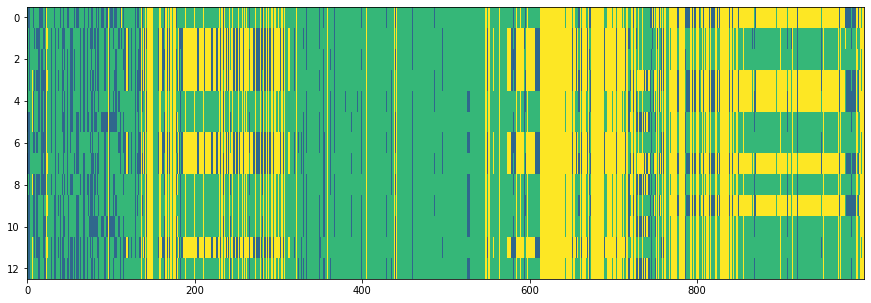

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(gen_data[:, :1000].A, aspect='auto', vmin=-1, vmax=2)
plt.show()

In [ ]:
for i in range(1, chrom_coord.shape[0]):
    if chrom_coord[i] == chrom_coord[i-1]:
        print(chrom_coord[i-1], chrom_coord[i])
        print(gen_data[:, i-1:i+1].A)